In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import time

## Data Loading

- SImple loading from csv and preview


In [17]:
# Load data
train_csv = "data/train.csv"
train_data = pd.read_csv(train_csv)

train_data.tail()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False
8692,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True


## Cleaning: Dropping rows with NaN values

- Train set:
  - Here, we drop rows with NaN values from thre training set.
- Test set:
  - The rows with NaN values from the test set are not dropped as they should be imputed or filled. This is done not miss any examples from the test set and the sumbission results.


In [18]:
from utils import drop_null_rows

# Missing values
print("Missing Train:", train_data.isnull().sum().sum())
train_data = drop_null_rows(train_data)
print("Missing Train after cleaning:", train_data.isnull().sum().sum())

Missing Train: 2324
Missing Train after cleaning: 0


## Preprocessing

- **Categorical features:**
  - "HomePlanet": Is dropped
  - "Cabin": Might be important -> split and use as an ordinal cat. feature
  - "Destination": Might be important -> split and use as an ordinal cat. feature
- **Numeric Features:** All used and normalized (later)
- **Unique features:**
  - "Name": Is dropped
  - "PassengerId": Might be important, they are used to create numeric features Id0 and Id1 respectively
- **Boolean features:** All used and are converted to int and normalized (later)


In [19]:
from utils import drop_columns, boolean2int

# Feature types
columns_to_drop = ["HomePlanet", "Name"]
numerical_feat = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
categorical_feat = ["Cabin", "Destination"]
boolean_feat = ["CryoSleep", "VIP"]
target = ["Transported"]

# Drop columns
train_data = drop_columns(train_data, columns=columns_to_drop)

# Convert to boolean
train_data = boolean2int(train_data, boolean_feat + target)

# print(train_data.isna().sum())
train_data.head()

,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0
1,0002_01,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1
2,0003_01,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0
3,0003_02,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0
4,0004_01,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1


- Creating new features from the strings for "Cabin" and "Destination" and conversion to categorical ints


In [20]:
# Feature Engineering
train_data[["Id0", "Id1"]] = (
    train_data["PassengerId"].str.split("_", expand=True).astype(int)
)
train_data[["Cabin0", "Cabin1", "Cabin2"]] = train_data["Cabin"].str.split(
    "/", expand=True
)

new_categorical_feat = ["Cabin0", "Cabin2", "Destination"]
train_data[new_categorical_feat] = train_data[new_categorical_feat].astype("category")
train_data[new_categorical_feat] = train_data[new_categorical_feat].apply(
    lambda x: x.cat.codes
)

train_data.head()

,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Id0,Id1,Cabin0,Cabin1,Cabin2
0,0001_01,0,B/0/P,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,0,0
1,0002_01,0,F/0/S,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1,2,1,5,0,1
2,0003_01,0,A/0/S,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,3,1,0,0,1
3,0003_02,0,A/0/S,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,3,2,0,0,1
4,0004_01,0,F/1/S,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1,4,1,5,1,1


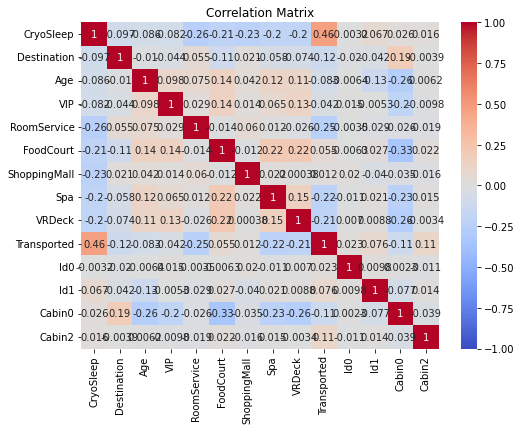

In [21]:
# Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(train_data.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

## Training:

- Selecting features according to the previous information from the correlation matrix and the exaplined variance ratio


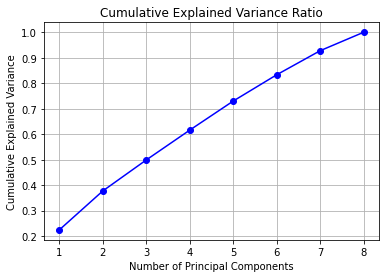

In [22]:
# Prepare X amd y matrices
features = [
    # "PassengerId",
    "CryoSleep",
    "Age",
    "VIP",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "Destination",
    "Id0",
    "Id1",
    "Cabin0",
    "Cabin1",
    "Cabin2",
]
target = ["Transported"]
X_train = train_data[features]
y_train = train_data[target].to_numpy().ravel()

X_train_copy = X_train.copy()  # used later for full training
y_train_copy = y_train.copy()  # used later for full training

# Plot explained variance ratio for need of dim reduction
scaler = StandardScaler()
data_standardized = scaler.fit_transform(X_train)

# Perform PCA
pca = PCA()
pca.fit(data_standardized)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_


# Plot the explained variance ratio
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
    linestyle="-",
    color="b",
)
plt.title("Cumulative Explained Variance Ratio")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

- Training with different models and sort the one with the highest validation accuracy


In [23]:
# Classification with sklearn
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    # "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", random_state=42),
    SVC(kernel="rbf", random_state=42),
    # GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(max_depth=5, random_state=42),
    MLPClassifier(max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

# Split train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

scores = pd.DataFrame(columns=["model", "val_acc", "time"])
# Iterate over classifiers
for name, clf in zip(names, classifiers):
    clf = make_pipeline(StandardScaler(), clf)

    start = time.time()
    clf.fit(X_train, y_train)
    elapsed = time.time() - start

    score = clf.score(X_val, y_val)

    scores = pd.concat(
        [
            scores,
            pd.DataFrame(
                [[name, score, elapsed]], columns=["model", "val_acc", "time"]
            ),
        ],
        ignore_index=True,
    )
scores.sort_values("val_acc", ascending=False)

c:\Users\diony\anaconda3\envs\env_torch\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


,model,val_acc,time
5,Neural Net,0.810797,3.306392
2,RBF SVM,0.802725,0.605301
4,Random Forest,0.795661,0.221186
6,AdaBoost,0.790111,0.161842
1,Linear SVM,0.787588,0.618225
3,Decision Tree,0.782038,0.007511
0,Nearest Neighbors,0.765388,0.008007
8,QDA,0.719475,0.005501
7,Naive Bayes,0.70888,0.004002


## Testing:

- Inference with the actaul test set, ready for submission


In [24]:
# Load the data
test_csv = "data/test.csv"
test_data = pd.read_csv(test_csv)

# Drop columns
test_data = drop_columns(test_data, columns=columns_to_drop)

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   CryoSleep     4184 non-null   object 
 2   Cabin         4177 non-null   object 
 3   Destination   4185 non-null   object 
 4   Age           4186 non-null   float64
 5   VIP           4184 non-null   object 
 6   RoomService   4195 non-null   float64
 7   FoodCourt     4171 non-null   float64
 8   ShoppingMall  4179 non-null   float64
 9   Spa           4176 non-null   float64
 10  VRDeck        4197 non-null   float64
dtypes: float64(6), object(5)
memory usage: 367.7+ KB


- Need to fill in the missing values for all required features of our model
  - this will increase the chance of making correct predictions and we wont miss any examples of the test


In [25]:
# Fill missing numerical values
test_data = test_data.fillna(test_data[numerical_feat].mean())

# Fill missing categorical values
test_data = test_data.apply(lambda x: x.fillna(x.mode()[0]))

# Convert to boolean
test_data = boolean2int(test_data, boolean_feat)

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   CryoSleep     4277 non-null   int32  
 2   Cabin         4277 non-null   object 
 3   Destination   4277 non-null   object 
 4   Age           4277 non-null   float64
 5   VIP           4277 non-null   int32  
 6   RoomService   4277 non-null   float64
 7   FoodCourt     4277 non-null   float64
 8   ShoppingMall  4277 non-null   float64
 9   Spa           4277 non-null   float64
 10  VRDeck        4277 non-null   float64
dtypes: float64(6), int32(2), object(3)
memory usage: 334.3+ KB


- Reapply the transforamtions fro "Cabin" and "Destination"


In [26]:
# Feature Engineering
test_data[["Id0", "Id1"]] = (
    test_data["PassengerId"].str.split("_", expand=True).astype(int)
)
test_data[["Cabin0", "Cabin1", "Cabin2"]] = test_data["Cabin"].str.split(
    "/", expand=True
)


new_categorical_feat = ["Cabin0", "Cabin2", "Destination"]
test_data[new_categorical_feat] = test_data[new_categorical_feat].astype("category")
test_data[new_categorical_feat] = test_data[new_categorical_feat].apply(
    lambda x: x.cat.codes
)

test_data.head()

,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Id0,Id1,Cabin0,Cabin1,Cabin2
0,0013_01,1,G/3/S,2,27.0,0,0.0,0.0,0.0,0.0,0.0,13,1,6,3,1
1,0018_01,0,F/4/S,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,18,1,5,4,1
2,0019_01,1,C/0/S,0,31.0,0,0.0,0.0,0.0,0.0,0.0,19,1,2,0,1
3,0021_01,0,C/1/S,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,21,1,2,1,1
4,0023_01,0,F/5/S,2,20.0,0,10.0,0.0,635.0,0.0,0.0,23,1,5,5,1


In [27]:
# Prepare X amd y matrices
X_test = test_data[features]

In [28]:
# Retrain with best clf
# clf = MLPClassifier(max_iter=1000, random_state=42)
clf = SVC(kernel="rbf", random_state=42)
clf = make_pipeline(StandardScaler(), clf)

clf.fit(X_train_copy, y_train_copy)

y_pred = clf.predict(X_test)

In [29]:
result = test_data[["PassengerId"]]
result["Transported"] = y_pred.astype(bool)

result.head()

C:\Users\diony\AppData\Local\Temp\ipykernel_29204\693111198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["Transported"] = y_pred.astype(bool)


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [30]:
result.to_csv('./submission_00_rbf.csv', index=False)